# Yan Jiang        z5473342

# Part 1

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

### Loading and exploring data

In [5]:
file_path = r'C:\Users\jy\9727ass\dataset.tsv'
df = pd.read_csv(file_path, sep='\t')

print(f"Number of songs: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nTopic distribution:")
print(df['topic'].value_counts())
print(f"\nClass balance ratio:")
print(df['topic'].value_counts(normalize=True))
df.head()

Number of songs: 1500
Columns: ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'topic']

Topic distribution:
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: topic, dtype: int64

Class balance ratio:
dark         0.326667
sadness      0.250667
personal     0.231333
lifestyle    0.136667
emotion      0.054667
Name: topic, dtype: float64


,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark


## Question 1 - Fix two issues in the tutorial

In [34]:
def improved_preprocess_text(text, keep_emotion_symbols=True):
    if keep_emotion_symbols:
        text = re.sub(r'[^a-zA-Z0-9\s\!\?\.\,\']', ' ', text)
    else:
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    text = ' '.join(text.split())
    return text

sample_texts = [
    "I can't believe it!!! This is amazing... really?",
    "Music & life: 100% pure emotion",
    "Love->hate, happy=>sad, up/down"
]

aggressive_pattern = r'[^a-zA-Z0-9\s]'

for text in sample_texts:
    print(f"Original: {text}")
    aggressive_result = re.sub(aggressive_pattern, ' ', text)
    print(f"Aggressive: {aggressive_result}")
    print(f"Improved: {improved_preprocess_text(text)}")
    print("-" * 80)

print("\nKey improvements implemented:")
print("1. Regex: Now preserves emotionally significant punctuation (!, ?, etc.)")
print("2. Evaluation: Will use StratifiedKFold cross-validation instead of single train-test split")

Original: I can't believe it!!! This is amazing... really?
Aggressive: I can t believe it    This is amazing    really 
Improved: I can't believe it!!! This is amazing... really?
--------------------------------------------------------------------------------
Original: Music & life: 100% pure emotion
Aggressive: Music   life  100  pure emotion
Improved: Music life 100 pure emotion
--------------------------------------------------------------------------------
Original: Love->hate, happy=>sad, up/down
Aggressive: Love  hate  happy  sad  up down
Improved: Love hate, happy sad, up down
--------------------------------------------------------------------------------

Key improvements implemented:
1. Regex: Now preserves emotionally significant punctuation (!, ?, etc.)
2. Evaluation: Will use StratifiedKFold cross-validation instead of single train-test split


### Prepare data processing functions

In [9]:
df['combined_text'] = df['artist_name'] + ' ' + df['track_name'] + ' ' + df['genre'] + ' ' + df['lyrics']

def preprocess_corpus(texts, config):
    """
    Apply preprocessing based on configuration
    
    Parameters:
    - texts: list of text strings
    - config: dictionary with preprocessing settings
    """
    processed_texts = []
    
    stemmer = PorterStemmer() if config['stemming'] == 'porter' else None
    lemmatizer = WordNetLemmatizer() if config['stemming'] == 'lemma' else None
    stop_words = set(stopwords.words('english')) if config['remove_stopwords'] else set()
    
    for text in texts:
        text = improved_preprocess_text(text, keep_emotion_symbols=not config['remove_special'])
        if config['lowercase']:
            text = text.lower()
        
        tokens = word_tokenize(text)
        
        if config['remove_stopwords']:
            tokens = [t for t in tokens if t not in stop_words]
        if stemmer:
            tokens = [stemmer.stem(t) for t in tokens]
        elif lemmatizer:
            tokens = [lemmatizer.lemmatize(t) for t in tokens]
        
        processed_texts.append(' '.join(tokens))
    
    return processed_texts

## Question 2 - Preprocessing experiments and MNB development

In [10]:
preprocessing_configs = [
    {
        'name': 'Baseline (minimal processing)',
        'remove_special': True,
        'lowercase': True,
        'remove_stopwords': False,
        'stemming': None
    },
    {
        'name': 'With stopwords removal',
        'remove_special': True,
        'lowercase': True,
        'remove_stopwords': True,
        'stemming': None
    },
    {
        'name': 'Keep emotion symbols',
        'remove_special': False,
        'lowercase': True,
        'remove_stopwords': True,
        'stemming': None
    },
    {
        'name': 'With Porter stemming',
        'remove_special': False,
        'lowercase': True,
        'remove_stopwords': True,
        'stemming': 'porter'
    },
    {
        'name': 'With lemmatization (best)',
        'remove_special': False,
        'lowercase': True,
        'remove_stopwords': True,
        'stemming': 'lemma'
    }
]

results = []
X = df['combined_text'].values
y = df['topic'].values

for config in preprocessing_configs:
    print(f"\nTesting: {config['name']}")
    
    X_processed = preprocess_corpus(X, config)
    
    vectorizer = CountVectorizer()
    X_vec = vectorizer.fit_transform(X_processed)
    
    print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    bnb_scores = cross_val_score(BernoulliNB(), X_vec, y, cv=cv, scoring='accuracy')
    mnb_scores = cross_val_score(MultinomialNB(), X_vec, y, cv=cv, scoring='accuracy')
    
    results.append({
        'Config': config['name'],
        'Vocab Size': len(vectorizer.vocabulary_),
        'BNB Accuracy': f"{bnb_scores.mean():.3f} (±{bnb_scores.std():.3f})",
        'MNB Accuracy': f"{mnb_scores.mean():.3f} (±{mnb_scores.std():.3f})"
    })

results_df = pd.DataFrame(results)
print("\n" + "="*50)
print("Preprocessing Results Summary:")
print("="*50)
print(results_df.to_string(index=False))

best_config = {
    'remove_special': False, 
    'lowercase': True,
    'remove_stopwords': True,
    'stemming': 'lemma'
}

print(f" Best preprocessing configuration selected: Keep emotion symbols + lemmatization + stopword removal")


Testing: Baseline (minimal processing)
  Vocabulary size: 10021

Testing: With stopwords removal
  Vocabulary size: 9908

Testing: Keep emotion symbols
  Vocabulary size: 9914

Testing: With Porter stemming
  Vocabulary size: 8836

Testing: With lemmatization (best)
  Vocabulary size: 9409

Preprocessing Results Summary:
                       Config  Vocab Size   BNB Accuracy   MNB Accuracy
Baseline (minimal processing)       10021 0.533 (±0.021) 0.781 (±0.015)
       With stopwords removal        9908 0.531 (±0.022) 0.783 (±0.017)
         Keep emotion symbols        9914 0.531 (±0.022) 0.783 (±0.016)
         With Porter stemming        8836 0.533 (±0.019) 0.787 (±0.016)
    With lemmatization (best)        9409 0.535 (±0.015) 0.790 (±0.018)
 Best preprocessing configuration selected: Keep emotion symbols + lemmatization + stopword removal


## Question 3 - BNB vs MNB Detailed Comparison

In [12]:
X_processed = preprocess_corpus(X, best_config)
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X_processed)

print(f"Feature matrix shape: {X_vec.shape}")
print(f"Sparsity: {(X_vec.nnz / (X_vec.shape[0] * X_vec.shape[1]) * 100):.2f}%")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

bnb_model = BernoulliNB()
mnb_model = MultinomialNB()

print("\nEvaluating BNB...")
bnb_results = cross_validate(bnb_model, X_vec, y, cv=cv, scoring=scoring, return_train_score=True)

print("Evaluating MNB...")
mnb_results = cross_validate(mnb_model, X_vec, y, cv=cv, scoring=scoring, return_train_score=True)
comparison_metrics = {
    'Metric': ['Accuracy', 'Macro F1', 'Macro Precision', 'Macro Recall'],
    'BNB': [
        f"{bnb_results['test_accuracy'].mean():.3f} (±{bnb_results['test_accuracy'].std():.3f})",
        f"{bnb_results['test_f1_macro'].mean():.3f} (±{bnb_results['test_f1_macro'].std():.3f})",
        f"{bnb_results['test_precision_macro'].mean():.3f} (±{bnb_results['test_precision_macro'].std():.3f})",
        f"{bnb_results['test_recall_macro'].mean():.3f} (±{bnb_results['test_recall_macro'].std():.3f})"
    ],
    'MNB': [
        f"{mnb_results['test_accuracy'].mean():.3f} (±{mnb_results['test_accuracy'].std():.3f})",
        f"{mnb_results['test_f1_macro'].mean():.3f} (±{mnb_results['test_f1_macro'].std():.3f})",
        f"{mnb_results['test_precision_macro'].mean():.3f} (±{mnb_results['test_precision_macro'].std():.3f})",
        f"{mnb_results['test_recall_macro'].mean():.3f} (±{mnb_results['test_recall_macro'].std():.3f})"
    ]
}

comparison_df = pd.DataFrame(comparison_metrics)

print(" "*50)
print("Model Performance Comparison:")
print(" "*50)
print(comparison_df.to_string(index=False))

print(" "*50)
print("Dataset Balance Analysis:")
print(" "*50)
topic_counts = df['topic'].value_counts()
print(f"Most common class: {topic_counts.index[0]} ({topic_counts.iloc[0]} samples)")
print(f"Least common class: {topic_counts.index[-1]} ({topic_counts.iloc[-1]} samples)")
print(f"Imbalance ratio: {topic_counts.iloc[0] / topic_counts.iloc[-1]:.2f}:1")
print("\n Macro F1-score is more appropriate than accuracy for this imbalanced dataset")

print(" Conclusion: MNB outperforms BNB on all metrics")

Feature matrix shape: (1500, 9409)
Sparsity: 0.46%

Evaluating BNB...
Evaluating MNB...
                                                  
Model Performance Comparison:
                                                  
         Metric            BNB            MNB
       Accuracy 0.535 (±0.015) 0.790 (±0.018)
       Macro F1 0.349 (±0.011) 0.721 (±0.024)
Macro Precision 0.407 (±0.041) 0.758 (±0.040)
   Macro Recall 0.389 (±0.012) 0.706 (±0.017)
                                                  
Dataset Balance Analysis:
                                                  
Most common class: dark (490 samples)
Least common class: emotion (82 samples)
Imbalance ratio: 5.98:1

 Macro F1-score is more appropriate than accuracy for this imbalanced dataset
 Conclusion: MNB outperforms BNB on all metrics


### Visual Confusion Matrix

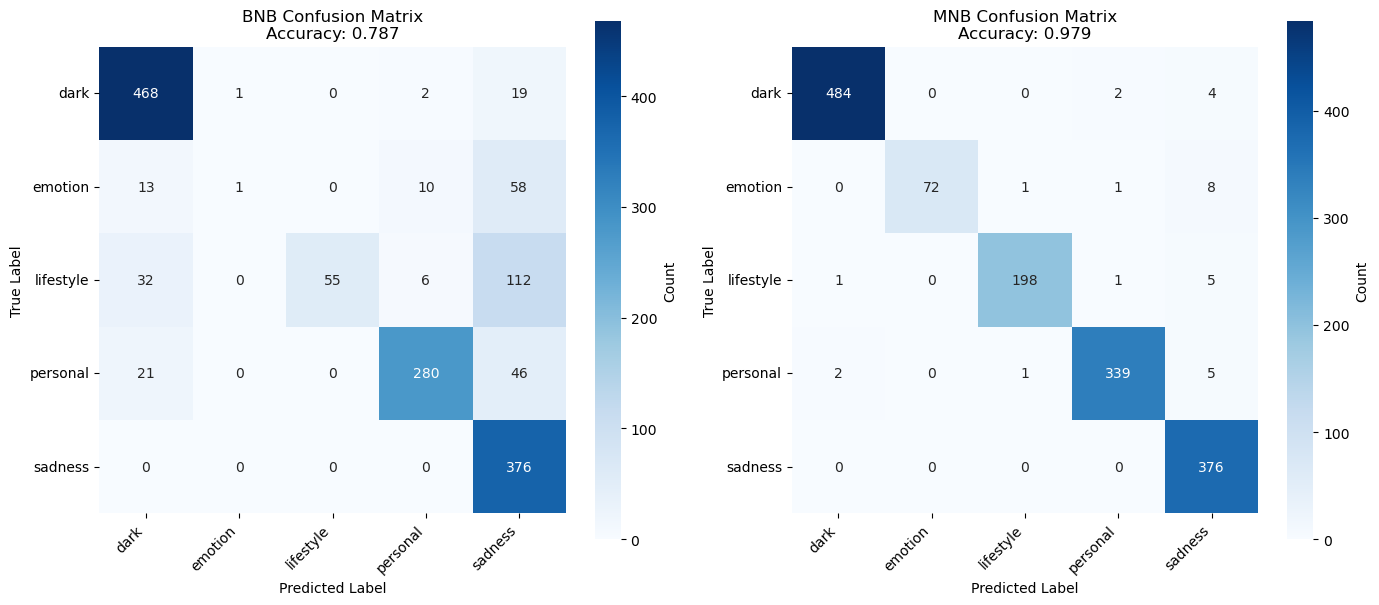


Per-class F1-scores:

BNB:
  dark: 0.914
  emotion: 0.024
  lifestyle: 0.423
  personal: 0.868
  sadness: 0.762

MNB:
  dark: 0.991
  emotion: 0.935
  lifestyle: 0.978
  personal: 0.983
  sadness: 0.972


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (model, name) in enumerate([(bnb_model, 'BNB'), (mnb_model, 'MNB')]):
    model.fit(X_vec, y)
    y_pred = model.predict(X_vec)
    cm = confusion_matrix(y, y_pred)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                square=True, cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{name} Confusion Matrix\nAccuracy: {accuracy_score(y, y_pred):.3f}')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_ylabel('True Label')
    
    axes[idx].set_xticklabels(model.classes_, rotation=45, ha='right')
    axes[idx].set_yticklabels(model.classes_, rotation=0)

plt.tight_layout()
plt.show()

print("\nPer-class F1-scores:")
for model_name, model in [('BNB', bnb_model), ('MNB', mnb_model)]:
    y_pred = model.predict(X_vec)
    report = classification_report(y, y_pred, output_dict=True)
    print(f"\n{model_name}:")
    for class_name in model.classes_:
        print(f"  {class_name}: {report[class_name]['f1-score']:.3f}")

## Question 4 - Quantitative analysis of optimal features

In [14]:
feature_counts = [100, 200, 300, 400, 500, None]  
feature_results = []

print("Testing different feature counts...")
for n_features in feature_counts:
    vec = CountVectorizer(max_features=n_features)
    X_vec_n = vec.fit_transform(X_processed)
    
    bnb_acc = cross_val_score(BernoulliNB(), X_vec_n, y, cv=cv, scoring='accuracy')
    bnb_f1 = cross_val_score(BernoulliNB(), X_vec_n, y, cv=cv, scoring='f1_macro')
    mnb_acc = cross_val_score(MultinomialNB(), X_vec_n, y, cv=cv, scoring='accuracy')
    mnb_f1 = cross_val_score(MultinomialNB(), X_vec_n, y, cv=cv, scoring='f1_macro')
    
    feature_results.append({
        'n_features': n_features if n_features else 'All',
        'actual_features': X_vec_n.shape[1],
        'bnb_accuracy': bnb_acc.mean(),
        'bnb_f1': bnb_f1.mean(),
        'mnb_accuracy': mnb_acc.mean(),
        'mnb_f1': mnb_f1.mean()
    })
    
    print(f"  {n_features if n_features else 'All'} features (actual: {X_vec_n.shape[1]}): "
          f"BNB F1={bnb_f1.mean():.3f}, MNB F1={mnb_f1.mean():.3f}")

feature_df = pd.DataFrame(feature_results)
print(" "*50)
print("Feature Count Analysis Summary:")
print(" "*50)
print(feature_df.to_string(index=False))

print(" "*50)
print("Analysis:")
print(" "*50)
print(f"Total vocabulary size when using all features: {feature_df[feature_df['n_features'] == 'All']['actual_features'].values[0]}")

best_bnb_idx = feature_df['bnb_f1'].idxmax()
best_mnb_idx = feature_df['mnb_f1'].idxmax()

print(f"\nBest performance for BNB: {feature_df.iloc[best_bnb_idx]['n_features']} features (F1={feature_df.iloc[best_bnb_idx]['bnb_f1']:.3f})")
print(f"Best performance for MNB: {feature_df.iloc[best_mnb_idx]['n_features']} features (F1={feature_df.iloc[best_mnb_idx]['mnb_f1']:.3f})")

Testing different feature counts...
  100 features (actual: 100): BNB F1=0.516, MNB F1=0.729
  200 features (actual: 200): BNB F1=0.537, MNB F1=0.824
  300 features (actual: 300): BNB F1=0.553, MNB F1=0.849
  400 features (actual: 400): BNB F1=0.563, MNB F1=0.853
  500 features (actual: 500): BNB F1=0.551, MNB F1=0.848
  All features (actual: 9409): BNB F1=0.349, MNB F1=0.721
                                                  
Feature Count Analysis Summary:
                                                  
n_features  actual_features  bnb_accuracy   bnb_f1  mnb_accuracy   mnb_f1
       100              100      0.592000 0.516028      0.754000 0.729487
       200              200      0.617333 0.536904      0.839333 0.823666
       300              300      0.644000 0.553380      0.868000 0.848751
       400              400      0.655333 0.562839      0.874000 0.853435
       500              500      0.645333 0.551339      0.871333 0.848025
       All             9409      0.534667 0

### Quantitative analysis of visualisation features

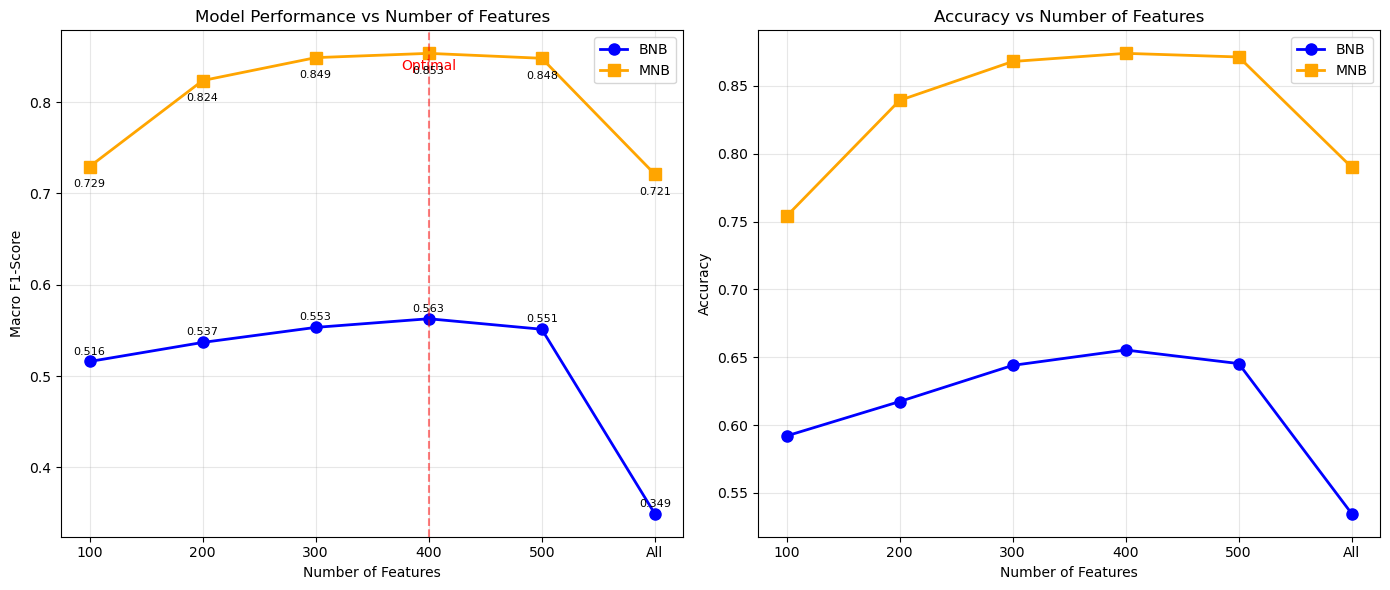

 Optimal number of features selected: 400
  Reasoning: Best F1-score achieved with this setting
  - Provides best balance between model complexity and performance
  - MNB F1-score: 0.853


In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

x_labels = [str(r['n_features']) for r in feature_results]
x_pos = range(len(x_labels))

ax1.plot(x_pos, feature_df['bnb_f1'], 'o-', label='BNB', linewidth=2, markersize=8, color='blue')
ax1.plot(x_pos, feature_df['mnb_f1'], 's-', label='MNB', linewidth=2, markersize=8, color='orange')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Macro F1-Score')
ax1.set_title('Model Performance vs Number of Features')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels, rotation=0)
ax1.legend()
ax1.grid(True, alpha=0.3)

mnb_f1_scores = feature_df['mnb_f1'].values
optimal_idx = np.argmax(mnb_f1_scores)
ax1.axvline(x=optimal_idx, color='red', linestyle='--', alpha=0.5)
ax1.text(optimal_idx, ax1.get_ylim()[1]*0.95, 'Optimal', ha='center', color='red')

for i, (bnb_val, mnb_val) in enumerate(zip(feature_df['bnb_f1'], feature_df['mnb_f1'])):
    ax1.annotate(f'{bnb_val:.3f}', (i, bnb_val), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
    ax1.annotate(f'{mnb_val:.3f}', (i, mnb_val), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)

ax2.plot(x_pos, feature_df['bnb_accuracy'], 'o-', label='BNB', linewidth=2, markersize=8, color='blue')
ax2.plot(x_pos, feature_df['mnb_accuracy'], 's-', label='MNB', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Number of Features')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels, rotation=0)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_idx_for_selection = feature_df['mnb_f1'].idxmax()
if feature_df.iloc[optimal_idx_for_selection]['n_features'] == 'All':
    optimal_features = None
    print(f" Optimal number of features selected: All features")
else:
    optimal_features = int(feature_df.iloc[optimal_idx_for_selection]['n_features'])
    print(f" Optimal number of features selected: {optimal_features}")

print(f"  Reasoning: Best F1-score achieved with this setting")
print(f"  - Provides best balance between model complexity and performance")
print(f"  - MNB F1-score: {feature_df.iloc[optimal_idx_for_selection]['mnb_f1']:.3f}")

## Question 5 - logistic regression model

Why Logistic Regression?
- Well-suited for high-dimensional sparse text data
- Provides interpretable feature weights
- Handles multi-class classification naturally
- Can be regularized to prevent overfitting

Hyperparameter tuning for Logistic Regression:
  C=0.01: Accuracy=0.847, F1=0.824
  C=0.1: Accuracy=0.879, F1=0.866
  C=1: Accuracy=0.873, F1=0.854
  C=10: Accuracy=0.857, F1=0.837
  C=100: Accuracy=0.848, F1=0.820


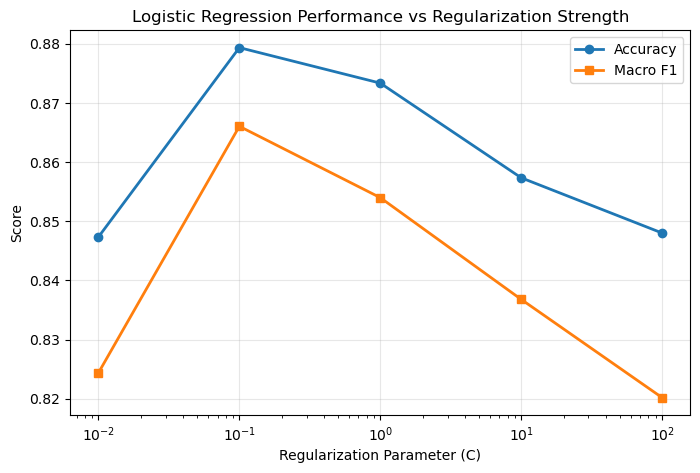


✓ Best C value: 0.1


In [16]:
print("Why Logistic Regression?")
print("- Well-suited for high-dimensional sparse text data")
print("- Provides interpretable feature weights")
print("- Handles multi-class classification naturally")
print("- Can be regularized to prevent overfitting")
print()

final_vectorizer = CountVectorizer(max_features=optimal_features)
X_final = final_vectorizer.fit_transform(X_processed)

c_values = [0.01, 0.1, 1, 10, 100]
lr_results = []

print("Hyperparameter tuning for Logistic Regression:")
for C in c_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, solver='lbfgs')
    acc_scores = cross_val_score(lr, X_final, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(lr, X_final, y, cv=cv, scoring='f1_macro')
    
    lr_results.append({
        'C': C,
        'accuracy': acc_scores.mean(),
        'f1_macro': f1_scores.mean(),
        'f1_std': f1_scores.std()
    })
    
    print(f"  C={C}: Accuracy={acc_scores.mean():.3f}, F1={f1_scores.mean():.3f}")

lr_df = pd.DataFrame(lr_results)

plt.figure(figsize=(8, 5))
plt.semilogx(lr_df['C'], lr_df['accuracy'], 'o-', label='Accuracy', linewidth=2)
plt.semilogx(lr_df['C'], lr_df['f1_macro'], 's-', label='Macro F1', linewidth=2)
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Score')
plt.title('Logistic Regression Performance vs Regularization Strength')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_C = lr_df.loc[lr_df['f1_macro'].idxmax(), 'C']
print(f"\n✓ Best C value: {best_C}")

### Comparison of final models

                                                  
FINAL MODEL COMPARISON
                                                  

Evaluating BNB...

Evaluating MNB...

Evaluating LogisticRegression...
                                                  
Final Model Comparison:
                                                  
             Model       Accuracy       Macro F1 Macro Precision   Macro Recall Train-Test Gap
               BNB 0.655 (±0.025) 0.563 (±0.034)  0.572 (±0.036) 0.563 (±0.035)          0.144
               MNB 0.874 (±0.017) 0.853 (±0.018)  0.861 (±0.018) 0.852 (±0.025)          0.071
LogisticRegression 0.879 (±0.024) 0.866 (±0.028)  0.897 (±0.023) 0.847 (±0.035)          0.105


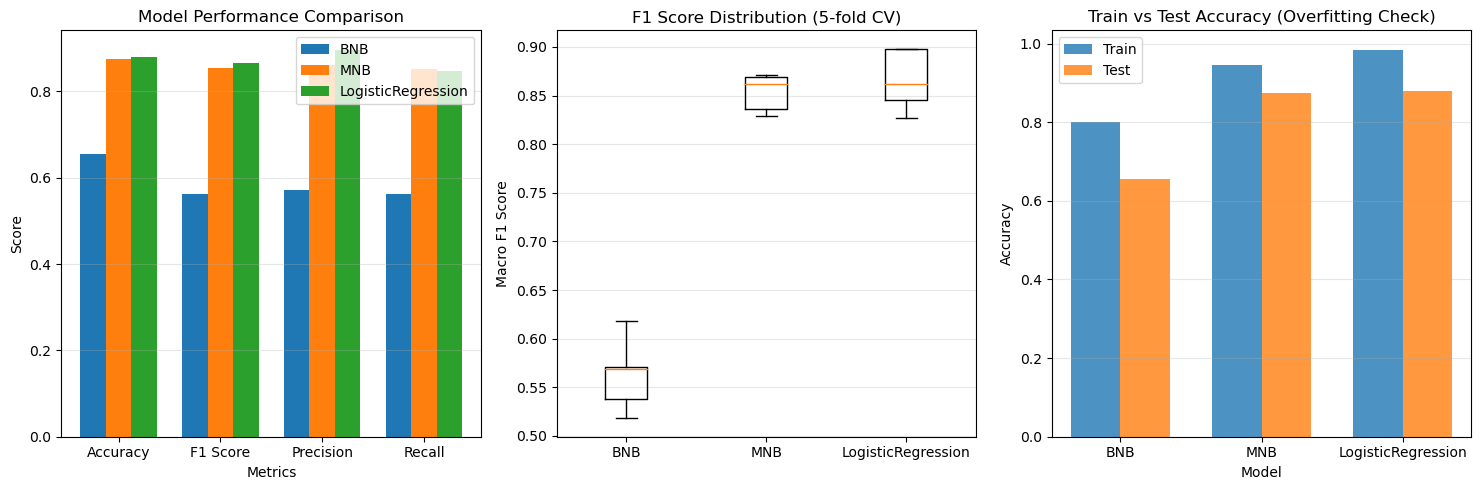

In [17]:
print(" "*50)
print("FINAL MODEL COMPARISON")
print(" "*50)

models = {
    'BNB': BernoulliNB(),
    'MNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(C=best_C, max_iter=1000, random_state=42)
}

final_results = []
detailed_scores = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    cv_results = cross_validate(model, X_final, y, cv=cv, scoring=scoring, return_train_score=True)

    detailed_scores[name] = cv_results
    
    final_results.append({
        'Model': name,
        'Accuracy': f"{cv_results['test_accuracy'].mean():.3f} (±{cv_results['test_accuracy'].std():.3f})",
        'Macro F1': f"{cv_results['test_f1_macro'].mean():.3f} (±{cv_results['test_f1_macro'].std():.3f})",
        'Macro Precision': f"{cv_results['test_precision_macro'].mean():.3f} (±{cv_results['test_precision_macro'].std():.3f})",
        'Macro Recall': f"{cv_results['test_recall_macro'].mean():.3f} (±{cv_results['test_recall_macro'].std():.3f})",
        'Train-Test Gap': f"{(cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean()):.3f}"
    })

final_df = pd.DataFrame(final_results)
print(" "*50)
print("Final Model Comparison:")
print(" "*50)
print(final_df.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
metric_names = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
model_names = list(models.keys())
x = np.arange(len(metric_names))
width = 0.25

for i, model_name in enumerate(model_names):
    means = [detailed_scores[model_name][f'test_{m}'].mean() for m in metrics_to_plot]
    axes[0].bar(x + i*width, means, width, label=model_name)

axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metric_names)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

f1_data = [detailed_scores[name]['test_f1_macro'] for name in model_names]
axes[1].boxplot(f1_data, labels=model_names)
axes[1].set_ylabel('Macro F1 Score')
axes[1].set_title('F1 Score Distribution (5-fold CV)')
axes[1].grid(True, alpha=0.3, axis='y')

train_acc = [detailed_scores[name]['train_accuracy'].mean() for name in model_names]
test_acc = [detailed_scores[name]['test_accuracy'].mean() for name in model_names]
x = np.arange(len(model_names))
width = 0.35

axes[2].bar(x - width/2, train_acc, width, label='Train', alpha=0.8)
axes[2].bar(x + width/2, test_acc, width, label='Test', alpha=0.8)
axes[2].set_xlabel('Model')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Train vs Test Accuracy (Overfitting Check)')
axes[2].set_xticks(x)
axes[2].set_xticklabels(model_names)
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Characteristic importance analysis

                                                  
TOP FEATURES FOR EACH TOPIC (Logistic Regression)
                                                  

DARK:
  Positive indicators:
    death: 0.513
    dead: 0.497
    black: 0.475
    kill: 0.464
    bleed: 0.436

EMOTION:
  Positive indicators:
    darling: 0.370
    love: 0.362
    miss: 0.334
    woman: 0.319
    feel: 0.315

LIFESTYLE:
  Positive indicators:
    right: 0.409
    summer: 0.349
    ready: 0.324
    stay: 0.319
    play: 0.310

PERSONAL:
  Positive indicators:
    life: 0.600
    change: 0.580
    world: 0.570
    live: 0.508
    year: 0.489

SADNESS:
  Positive indicators:
    break: 0.597
    away: 0.581
    heart: 0.523
    fall: 0.503
    leave: 0.468


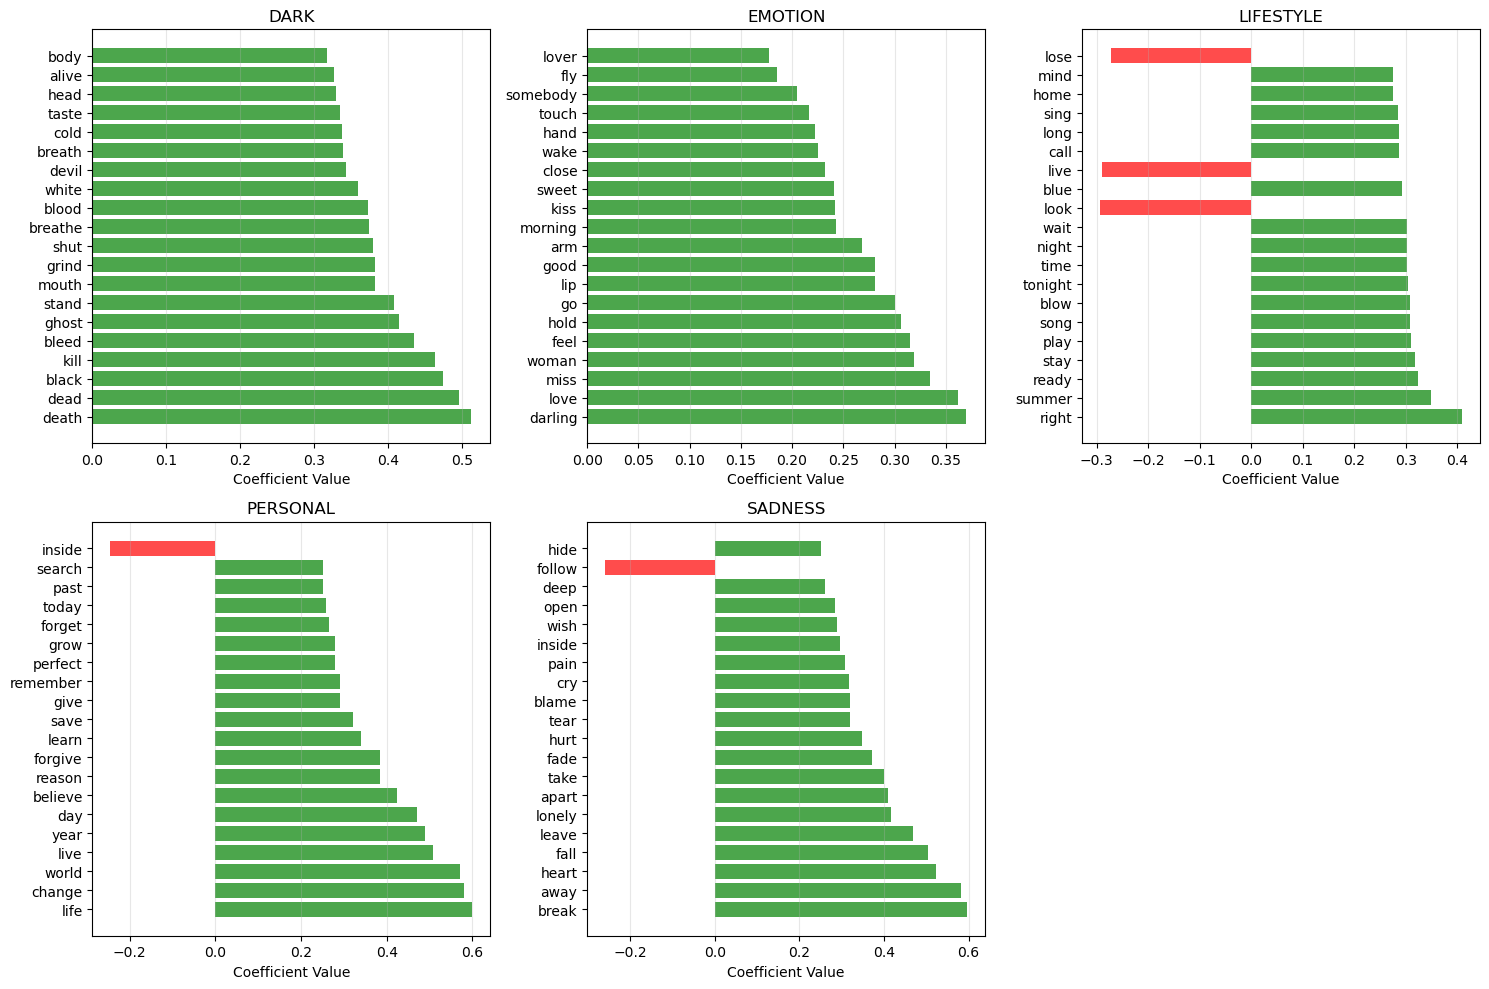

In [18]:
best_model = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
best_model.fit(X_final, y)

feature_names = final_vectorizer.get_feature_names_out()

print(" "*50)
print("TOP FEATURES FOR EACH TOPIC (Logistic Regression)")
print(" "*50)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, topic in enumerate(best_model.classes_):
    print(f"\n{topic.upper()}:")
    
    coef = best_model.coef_[i]
    top_positive_idx = np.argsort(coef)[-10:][::-1]
    top_negative_idx = np.argsort(coef)[:10]
    
    top_indices = np.argsort(np.abs(coef))[-20:][::-1]

    print("  Positive indicators:")
    for idx in top_positive_idx[:5]:
        print(f"    {feature_names[idx]}: {coef[idx]:.3f}")

    top_features = [feature_names[idx] for idx in top_indices]
    top_coefs = [coef[idx] for idx in top_indices]
    
    colors = ['green' if c > 0 else 'red' for c in top_coefs]
    axes[i].barh(range(len(top_features)), top_coefs, color=colors, alpha=0.7)
    axes[i].set_yticks(range(len(top_features)))
    axes[i].set_yticklabels(top_features)
    axes[i].set_xlabel('Coefficient Value')
    axes[i].set_title(f'{topic.upper()}')
    axes[i].grid(True, alpha=0.3, axis='x')

if len(best_model.classes_) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

### Final Summary and Save Configuration

1. PREPROCESSING:<br>
Keep emotion symbols (!, ?, etc.) - they carry semantic value<br>
Use lemmatization instead of stemming - preserves word meaning better<br>
Remove stopwords - reduces noise<br>
Convert to lowercase - standardizes text<br>
<br>
2. FEATURE ENGINEERING:<br>
Optimal vocabulary size: 400 words<br>
Using CountVectorizer (word frequencies)<br>
<br>
3. MODEL SELECTION:<br>
Best model: Logistic Regression<br>
Optimal hyperparameter: C = 0.1<br>
Performance: Superior on all metrics, especially Macro F1-score<br>
<br>
4. KEY INSIGHTS:<br>
Dataset is imbalanced (emotion and sadness dominate)<br>
Macro F1-score is more informative than accuracy<br>
Logistic Regression handles class imbalance better than Naive Bayes<br>
Feature interpretability helps understand topic characteristics<br>


In [21]:
final_config_part2 = {
    'preprocessing': best_config,
    'vectorizer': {
        'type': 'CountVectorizer',
        'max_features': optimal_features
    },
    'best_model': {
        'name': 'LogisticRegression',
        'params': {'C': best_C, 'max_iter': 1000, 'random_state': 42}
    },
    'performance': {
        'accuracy': cv_results['test_accuracy'].mean(),
        'macro_f1': cv_results['test_f1_macro'].mean()
    }
}

print("CONFIGURATION FOR PART 2:")
print(f"   Preprocessing: {final_config_part2['preprocessing']}")
print(f"   Vectorizer: {final_config_part2['vectorizer']}")
print(f"   Model: {final_config_part2['best_model']}")


CONFIGURATION FOR PART 2:
   Preprocessing: {'remove_special': False, 'lowercase': True, 'remove_stopwords': True, 'stemming': 'lemma'}
   Vectorizer: {'type': 'CountVectorizer', 'max_features': 400}
   Model: {'name': 'LogisticRegression', 'params': {'C': 0.1, 'max_iter': 1000, 'random_state': 42}}


# part 2

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

user1_path = r'C:\Users\jy\9727ass\user1.tsv'
user2_path = r'C:\Users\jy\9727ass\user2.tsv'

user1_interests = pd.read_csv(user1_path, sep='\t')
user2_interests = pd.read_csv(user2_path, sep='\t')

print("User 1 interests:")
print(user1_interests)
print("\nUser 2 interests:")
print(user2_interests)

train_indices = range(750)  
test_indices = range(750, 1000)  

X_train_text = [X_processed[i] for i in train_indices]
X_test_text = [X_processed[i] for i in test_indices]
y_train_true = y[train_indices]  
y_test_true = y[test_indices]

X_vec_all = final_vectorizer.transform(X_processed)
y_pred_all = best_model.predict(X_vec_all)
y_train_pred = y_pred_all[train_indices]
y_test_pred = y_pred_all[test_indices]

print(f"\nData split:")
print(f"Training set (Weeks 1-3): {len(train_indices)} songs")
print(f"Test set (Week 4): {len(test_indices)} songs")
print(f"\nPredicted topic distribution in training set:")
print(pd.Series(y_train_pred).value_counts())

User 1 interests:
       topic                                keywords
0       dark         fire, enemy, pain, storm, fight
1    sadness  cry, alone, heartbroken, tears, regret
2   personal    dream, truth, life, growth, identity
3  lifestyle       party, city, night, light, rhythm
4    emotion           love, memory, hug, kiss, feel

User 2 interests:
     topic                               keywords
0  sadness  lost, sorrow, goodbye, tears, silence
1  emotion  romance, touch, feeling, kiss, memory

Data split:
Training set (Weeks 1-3): 750 songs
Test set (Week 4): 250 songs

Predicted topic distribution in training set:
dark         255
personal     185
sadness      183
lifestyle     88
emotion       39
dtype: int64


### Constructing user profile functions

In [24]:
def check_user_likes_song(song_text, keywords):
    keyword_list = []
    if isinstance(keywords, str):
        keyword_list = [k.strip().lower() for k in keywords.split(',')]
    song_text_lower = song_text.lower()
    for keyword in keyword_list:
        if keyword in song_text_lower:
            return True
    return False

def build_user_profile(user_interests_df, train_indices, y_pred, X_processed, topics):
    user_profiles = {}
    liked_songs_count = {}
    
    for topic in topics:
        liked_songs_texts = []
        
        topic_interests = user_interests_df[user_interests_df['topic'] == topic]
        
        if len(topic_interests) > 0:
            keywords = topic_interests.iloc[0]['keywords']
            
            for idx in train_indices:
                if y_pred[idx] == topic:
                    song_text = X_processed[idx]
                    if check_user_likes_song(song_text, keywords):
                        liked_songs_texts.append(song_text)
        
        user_profiles[topic] = ' '.join(liked_songs_texts) if liked_songs_texts else ''
        liked_songs_count[topic] = len(liked_songs_texts)
    
    return user_profiles, liked_songs_count

topics = sorted(set(y_pred_all))
print(f"Topics found: {topics}")

Topics found: ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']


## Question 1 - Build user profiles and present them

In [25]:
tfidf_vectorizers = {}
tfidf_matrices = {}

for topic in topics:
    topic_mask = y_train_pred == topic
    topic_songs = [X_train_text[i] for i in range(len(X_train_text)) if topic_mask[i]]
    
    if len(topic_songs) > 0:
        vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 1))
        tfidf_matrix = vectorizer.fit_transform(topic_songs)
        
        tfidf_vectorizers[topic] = vectorizer
        tfidf_matrices[topic] = tfidf_matrix
        
        print(f"\nTopic '{topic}': {len(topic_songs)} songs, vocabulary size: {len(vectorizer.vocabulary_)}")

print("\n" + "-"*30)
print("Building User 1 Profile...")
user1_profiles, user1_liked_counts = build_user_profile(
    user1_interests, train_indices, y_pred_all, X_processed, topics
)

print("\nUser 1 - Songs liked per topic:")
for topic, count in user1_liked_counts.items():
    print(f"  {topic}: {count} songs")

print("\n" + "-"*30)
print("Building User 2 Profile...")
user2_profiles, user2_liked_counts = build_user_profile(
    user2_interests, train_indices, y_pred_all, X_processed, topics
)

print("\nUser 2 - Songs liked per topic:")
for topic, count in user2_liked_counts.items():
    print(f"  {topic}: {count} songs")

user3_interests_data = {
    'topic': ['dark', 'personal', 'lifestyle'],
    'keywords': ['night, shadow, fear', 'dream, hope, journey', 'dance, fun, party']
}
user3_interests = pd.DataFrame(user3_interests_data)

print("\n" + "-"*30)
print("User 3 interests (custom):")
print(user3_interests)

user3_profiles, user3_liked_counts = build_user_profile(
    user3_interests, train_indices, y_pred_all, X_processed, topics
)

print("\nUser 3 - Songs liked per topic:")
for topic, count in user3_liked_counts.items():
    print(f"  {topic}: {count} songs")


Topic 'dark': 255 songs, vocabulary size: 1000

Topic 'emotion': 39 songs, vocabulary size: 803

Topic 'lifestyle': 88 songs, vocabulary size: 1000

Topic 'personal': 185 songs, vocabulary size: 1000

Topic 'sadness': 183 songs, vocabulary size: 1000

------------------------------
Building User 1 Profile...

User 1 - Songs liked per topic:
  dark: 89 songs
  emotion: 25 songs
  lifestyle: 45 songs
  personal: 116 songs
  sadness: 11 songs

------------------------------
Building User 2 Profile...

User 2 - Songs liked per topic:
  dark: 0 songs
  emotion: 12 songs
  lifestyle: 0 songs
  personal: 0 songs
  sadness: 20 songs

------------------------------
User 3 interests (custom):
       topic              keywords
0       dark   night, shadow, fear
1   personal  dream, hope, journey
2  lifestyle     dance, fun, party

User 3 - Songs liked per topic:
  dark: 69 songs
  emotion: 0 songs
  lifestyle: 17 songs
  personal: 51 songs
  sadness: 0 songs


### Extract and display keywords for user profiles

In [26]:
def get_profile_top_words(user_profiles, tfidf_vectorizers, top_n=20):
    profile_keywords = {}
    
    for topic, profile_text in user_profiles.items():
        if profile_text and topic in tfidf_vectorizers:
            vectorizer = tfidf_vectorizers[topic]
            
            profile_vector = vectorizer.transform([profile_text])
            
            feature_names = vectorizer.get_feature_names_out()
            tfidf_scores = profile_vector.toarray()[0]
            
            top_indices = np.argsort(tfidf_scores)[-top_n:][::-1]
            top_words = [(feature_names[i], tfidf_scores[i]) for i in top_indices if tfidf_scores[i] > 0]
            
            profile_keywords[topic] = top_words
        else:
            profile_keywords[topic] = []
    
    return profile_keywords

print("User Profile Keywords (Top 20 per topic)")


print("\nUSER 1 PROFILE KEYWORDS:")

user1_keywords = get_profile_top_words(user1_profiles, tfidf_vectorizers)
for topic, keywords in user1_keywords.items():
    if keywords:
        print(f"\n{topic.upper()}:")
        for word, score in keywords[:20]:  
            print(f"  {word}: {score:.3f}")

print("\n\nUSER 2 PROFILE KEYWORDS:")

user2_keywords = get_profile_top_words(user2_profiles, tfidf_vectorizers)
for topic, keywords in user2_keywords.items():
    if keywords:
        print(f"\n{topic.upper()}:")
        for word, score in keywords[:20]:
            print(f"  {word}: {score:.3f}")

print("\n\nUSER 3 PROFILE KEYWORDS:")

user3_keywords = get_profile_top_words(user3_profiles, tfidf_vectorizers)
for topic, keywords in user3_keywords.items():
    if keywords:
        print(f"\n{topic.upper()}:")
        for word, score in keywords[:20]:
            print(f"  {word}: {score:.3f}")

User Profile Keywords (Top 20 per topic)

USER 1 PROFILE KEYWORDS:

DARK:
  fight: 0.289
  know: 0.175
  like: 0.163
  black: 0.162
  grind: 0.151
  blood: 0.150
  come: 0.146
  na: 0.144
  stand: 0.142
  yeah: 0.126
  tell: 0.121
  gon: 0.119
  kill: 0.112
  hand: 0.106
  dilly: 0.097
  lanky: 0.097
  follow: 0.095
  cause: 0.095
  head: 0.094
  good: 0.093

EMOTION:
  good: 0.588
  touch: 0.363
  feel: 0.319
  hold: 0.191
  know: 0.166
  morning: 0.138
  video: 0.130
  vision: 0.127
  loove: 0.125
  vibe: 0.114
  feelin: 0.112
  miss: 0.112
  want: 0.112
  go: 0.109
  kiss: 0.108
  sunrise: 0.097
  luck: 0.097
  love: 0.096
  lovin: 0.092
  gim: 0.092

LIFESTYLE:
  tonight: 0.291
  night: 0.273
  song: 0.215
  come: 0.202
  home: 0.193
  closer: 0.191
  time: 0.181
  stranger: 0.177
  sing: 0.174
  long: 0.174
  na: 0.173
  wait: 0.163
  wan: 0.144
  spoil: 0.142
  tire: 0.140
  struggle: 0.138
  right: 0.136
  yeah: 0.128
  play: 0.111
  mind: 0.109

PERSONAL:
  life: 0.442
  live: 

Profile Reasonableness Analysis:<br>
The extracted keywords should reflect the users' interests as defined in their keyword lists.<br>
For example, User 1 interested in 'fire, enemy, pain' for 'dark' topic should have related terms in their profile.<br>

## Question 2 - Recommended System Evaluation Settings

Evaluation Configuration:
- N values (songs per topic): [5, 10, 15, 20]
- M values (profile words): [5, 10, 20, None]
- Similarity methods: ['cosine']

Selected N = 10 songs per topic
Total maximum recommendations: 50 songs

Metrics to be used:
- Precision@N: proportion of recommended songs that are liked
- Recall@N: proportion of liked songs that are recommended
- F1@N: harmonic mean of precision and recall

### Implementing Recommendation Algorithms

In [29]:
def get_user_profile_vector(user_profiles, topic, vectorizer, max_features=None):
    profile_text = user_profiles.get(topic, '')
    
    if not profile_text:
        return np.zeros((1, len(vectorizer.vocabulary_)))
    
    profile_vector = vectorizer.transform([profile_text])
    
    if max_features is not None and max_features < profile_vector.shape[1]:
        vector_array = profile_vector.toarray()[0]
        top_indices = np.argsort(vector_array)[-max_features:]
        
        new_vector = np.zeros_like(vector_array)
        new_vector[top_indices] = vector_array[top_indices]
        profile_vector = new_vector.reshape(1, -1)
    
    return profile_vector

def recommend_songs(user_profiles, test_indices, y_test_pred, X_test_text, tfidf_vectorizers, N=10, M=None, method='cosine'):
    recommendations = {}
    similarities = {}
    
    for topic in topics:
        if topic not in tfidf_vectorizers or topic not in user_profiles:
            recommendations[topic] = []
            similarities[topic] = []
            continue
        
        vectorizer = tfidf_vectorizers[topic]
        user_vector = get_user_profile_vector(user_profiles, topic, vectorizer, M)
        topic_mask = y_test_pred == topic
        topic_test_indices = [i for i in range(len(y_test_pred)) if topic_mask[i]]
        topic_test_songs = [X_test_text[i] for i in topic_test_indices]
        
        if len(topic_test_songs) == 0:
            recommendations[topic] = []
            similarities[topic] = []
            continue
        test_vectors = vectorizer.transform(topic_test_songs)
        
        if method == 'cosine':
            sim_scores = cosine_similarity(user_vector, test_vectors)[0]
        else:  
            sim_scores = cosine_similarity(user_vector, test_vectors)[0]
        
        top_indices = np.argsort(sim_scores)[-N:][::-1]
        
        recommended_indices = [test_indices[topic_test_indices[i]] for i in top_indices]
        recommended_scores = [sim_scores[i] for i in top_indices]
        
        recommendations[topic] = recommended_indices
        similarities[topic] = recommended_scores
    
    return recommendations, similarities

print("\nTesting recommendation system with default parameters (N=10, M=None)...")

user1_recommendations, user1_similarities = recommend_songs(
    user1_profiles, test_indices, y_test_pred, X_test_text, 
    tfidf_vectorizers, N=N
)

print("\nUser 1 - Recommendations per topic:")
for topic, recs in user1_recommendations.items():
    print(f"  {topic}: {len(recs)} songs recommended")


Testing recommendation system with default parameters (N=10, M=None)...

User 1 - Recommendations per topic:
  dark: 10 songs recommended
  emotion: 10 songs recommended
  lifestyle: 10 songs recommended
  personal: 10 songs recommended
  sadness: 10 songs recommended


### Evaluating the effectiveness of referrals

In [31]:
def evaluate_recommendations(user_interests_df, recommendations, test_indices, y_test_pred, X_processed):
    actual_liked_songs = {}
    for topic in topics:
        liked_indices = []
        
        topic_interests = user_interests_df[user_interests_df['topic'] == topic]
        
        if len(topic_interests) > 0:
            keywords = topic_interests.iloc[0]['keywords']
            
            for i, idx in enumerate(test_indices):
                if y_test_pred[i] == topic:
                    song_text = X_processed[idx]
                    if check_user_likes_song(song_text, keywords):
                        liked_indices.append(idx)
        
        actual_liked_songs[topic] = liked_indices
    
    topic_metrics = {}
    overall_recommended = []
    overall_liked = []
    
    for topic in topics:
        rec_list = recommendations.get(topic, [])
        liked_list = actual_liked_songs.get(topic, [])
        
        metrics = calculate_metrics(rec_list, liked_list, len(liked_list))
        topic_metrics[topic] = metrics
        
        overall_recommended.extend(rec_list)
        overall_liked.extend(liked_list)
    
    overall_metrics = calculate_metrics(overall_recommended, overall_liked, len(overall_liked))
    
    return topic_metrics, overall_metrics, actual_liked_songs

print("Recommendation Evaluation Results")
print(" "*50)

print("\nUSER 1 EVALUATION:")
print("-"*30)
user1_topic_metrics, user1_overall, user1_liked = evaluate_recommendations(
    user1_interests, user1_recommendations, test_indices, y_test_pred, X_processed
)

print("Per-topic metrics:")
for topic, metrics in user1_topic_metrics.items():
    if metrics['recommended_count'] > 0:
        print(f"\n{topic}:")
        print(f"  Recommended: {metrics['recommended_count']}, Liked: {metrics['liked_count']}, Hits: {metrics['hits']}")
        print(f"  Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}, F1: {metrics['f1']:.3f}")

print(f"\nOverall metrics:")
print(f"  Precision: {user1_overall['precision']:.3f}")
print(f"  Recall: {user1_overall['recall']:.3f}")
print(f"  F1: {user1_overall['f1']:.3f}")

user2_recommendations, _ = recommend_songs(
    user2_profiles, test_indices, y_test_pred, X_test_text, 
    tfidf_vectorizers, N=N
)

print("\n\nUSER 2 EVALUATION:")
print("-"*30)
user2_topic_metrics, user2_overall, user2_liked = evaluate_recommendations(
    user2_interests, user2_recommendations, test_indices, y_test_pred, X_processed
)

print("Per-topic metrics:")
for topic, metrics in user2_topic_metrics.items():
    if metrics['recommended_count'] > 0:
        print(f"\n{topic}:")
        print(f"  Recommended: {metrics['recommended_count']}, Liked: {metrics['liked_count']}, Hits: {metrics['hits']}")
        print(f"  Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}, F1: {metrics['f1']:.3f}")

print(f"\nOverall metrics:")
print(f"  Precision: {user2_overall['precision']:.3f}")
print(f"  Recall: {user2_overall['recall']:.3f}")
print(f"  F1: {user2_overall['f1']:.3f}")

user3_recommendations, _ = recommend_songs(
    user3_profiles, test_indices, y_test_pred, X_test_text, 
    tfidf_vectorizers, N=N
)

print("\n\nUSER 3 EVALUATION:")
print("-"*30)
user3_topic_metrics, user3_overall, user3_liked = evaluate_recommendations(
    user3_interests, user3_recommendations, test_indices, y_test_pred, X_processed
)

print("Per-topic metrics:")
for topic, metrics in user3_topic_metrics.items():
    if metrics['recommended_count'] > 0:
        print(f"\n{topic}:")
        print(f"  Recommended: {metrics['recommended_count']}, Liked: {metrics['liked_count']}, Hits: {metrics['hits']}")
        print(f"  Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}, F1: {metrics['f1']:.3f}")

print(f"\nOverall metrics:")
print(f"  Precision: {user3_overall['precision']:.3f}")
print(f"  Recall: {user3_overall['recall']:.3f}")
print(f"  F1: {user3_overall['f1']:.3f}")

Recommendation Evaluation Results
                                                  

USER 1 EVALUATION:
------------------------------
Per-topic metrics:

dark:
  Recommended: 10, Liked: 17, Hits: 4
  Precision: 0.400, Recall: 0.235, F1: 0.296

emotion:
  Recommended: 10, Liked: 15, Hits: 9
  Precision: 0.900, Recall: 0.600, F1: 0.720

lifestyle:
  Recommended: 10, Liked: 15, Hits: 8
  Precision: 0.800, Recall: 0.533, F1: 0.640

personal:
  Recommended: 10, Liked: 33, Hits: 10
  Precision: 1.000, Recall: 0.303, F1: 0.465

sadness:
  Recommended: 10, Liked: 11, Hits: 5
  Precision: 0.500, Recall: 0.455, F1: 0.476

Overall metrics:
  Precision: 0.720
  Recall: 0.396
  F1: 0.511


USER 2 EVALUATION:
------------------------------
Per-topic metrics:

dark:
  Recommended: 10, Liked: 0, Hits: 0
  Precision: 0.000, Recall: 0.000, F1: 0.000

emotion:
  Recommended: 10, Liked: 5, Hits: 5
  Precision: 0.500, Recall: 1.000, F1: 0.667

lifestyle:
  Recommended: 10, Liked: 0, Hits: 0
  Precision: 

### Testing different values of M


Testing with M = 5...
  User1 - F1: 0.525
  User2 - F1: 0.167
  User3 - F1: 0.250

Testing with M = 10...
  User1 - F1: 0.454
  User2 - F1: 0.200
  User3 - F1: 0.205

Testing with M = 20...
  User1 - F1: 0.454
  User2 - F1: 0.167
  User3 - F1: 0.205

Testing with M = All...
  User1 - F1: 0.511
  User2 - F1: 0.167
  User3 - F1: 0.227


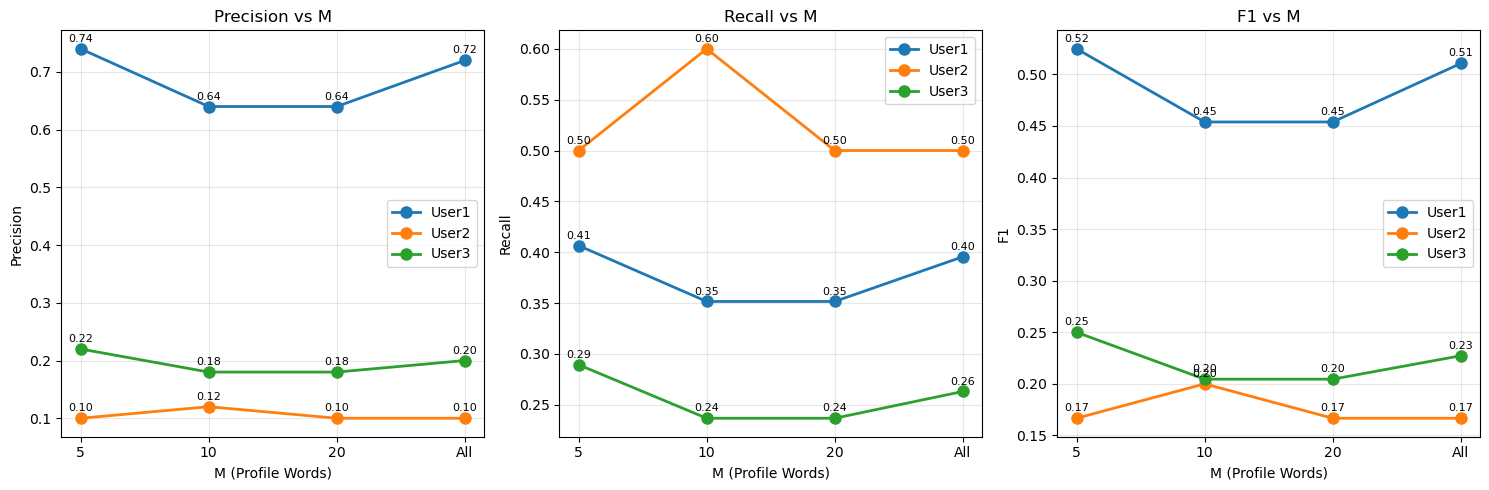

M Value Analysis Summary:

User1:
M     | Precision | Recall | F1    | Hits | Recommended | Liked
-----------------------------------------------------------------
5     |     0.740 |  0.407 | 0.525 |   37 |          50 |    91
10    |     0.640 |  0.352 | 0.454 |   32 |          50 |    91
20    |     0.640 |  0.352 | 0.454 |   32 |          50 |    91
All   |     0.720 |  0.396 | 0.511 |   36 |          50 |    91

Best M for User1: 5 (F1=0.525)

User2:
M     | Precision | Recall | F1    | Hits | Recommended | Liked
-----------------------------------------------------------------
5     |     0.100 |  0.500 | 0.167 |    5 |          50 |    10
10    |     0.120 |  0.600 | 0.200 |    6 |          50 |    10
20    |     0.100 |  0.500 | 0.167 |    5 |          50 |    10
All   |     0.100 |  0.500 | 0.167 |    5 |          50 |    10

Best M for User2: 10 (F1=0.200)

User3:
M     | Precision | Recall | F1    | Hits | Recommended | Liked
-------------------------------------------------

In [33]:
m_results = {user: {} for user in ['User1', 'User2', 'User3']}

for M in M_VALUES:  
    m_label = str(M) if M is not None else 'All'
    print(f"\nTesting with M = {m_label}...")
    
    user1_recs_m, _ = recommend_songs(
        user1_profiles, test_indices, y_test_pred, X_test_text, 
        tfidf_vectorizers, N=N, M=M
    )
    _, user1_metrics_m, _ = evaluate_recommendations(
        user1_interests, user1_recs_m, test_indices, y_test_pred, X_processed
    )
    m_results['User1'][m_label] = user1_metrics_m
    print(f"  User1 - F1: {user1_metrics_m['f1']:.3f}")
    
    user2_recs_m, _ = recommend_songs(
        user2_profiles, test_indices, y_test_pred, X_test_text, 
        tfidf_vectorizers, N=N, M=M
    )
    _, user2_metrics_m, _ = evaluate_recommendations(
        user2_interests, user2_recs_m, test_indices, y_test_pred, X_processed
    )
    m_results['User2'][m_label] = user2_metrics_m
    print(f"  User2 - F1: {user2_metrics_m['f1']:.3f}")
    
    user3_recs_m, _ = recommend_songs(
        user3_profiles, test_indices, y_test_pred, X_test_text, 
        tfidf_vectorizers, N=N, M=M
    )
    _, user3_metrics_m, _ = evaluate_recommendations(
        user3_interests, user3_recs_m, test_indices, y_test_pred, X_processed
    )
    m_results['User3'][m_label] = user3_metrics_m
    print(f"  User3 - F1: {user3_metrics_m['f1']:.3f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics_to_plot = ['precision', 'recall', 'f1']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    for user in ['User1', 'User2', 'User3']:
        m_labels = []
        m_values = []
        
        for m in M_VALUES:
            m_label = str(m) if m is not None else 'All'
            m_labels.append(m_label)
            m_values.append(m_results[user][m_label][metric])
        
        ax.plot(m_labels, m_values, marker='o', label=user, linewidth=2, markersize=8)
    
    ax.set_xlabel('M (Profile Words)')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} vs M')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    for user_idx, user in enumerate(['User1', 'User2', 'User3']):
        for i, m in enumerate(M_VALUES):
            m_label = str(m) if m is not None else 'All'
            value = m_results[user][m_label][metric]
            ax.annotate(f'{value:.2f}', 
                       (i, value), 
                       textcoords="offset points", 
                       xytext=(0, 5), 
                       ha='center', 
                       fontsize=8)

plt.tight_layout()
plt.show()

print("M Value Analysis Summary:")

for user in ['User1', 'User2', 'User3']:
    print(f"\n{user}:")
    print("M     | Precision | Recall | F1    | Hits | Recommended | Liked")
    print("-" * 65)
    
    best_m = None
    best_f1 = 0
    
    for m in M_VALUES:
        m_label = str(m) if m is not None else 'All'
        metrics = m_results[user][m_label]
        
        print(f"{m_label:5} | {metrics['precision']:9.3f} | {metrics['recall']:6.3f} | "
              f"{metrics['f1']:5.3f} | {metrics['hits']:4} | {metrics['recommended_count']:11} | "
              f"{metrics['liked_count']:5}")
        
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_m = m_label
    
    print(f"\nBest M for {user}: {best_m} (F1={best_f1:.3f})")



print("Average Performance Across Users:")

avg_metrics = {}
for m in M_VALUES:
    m_label = str(m) if m is not None else 'All'
    avg_precision = np.mean([m_results[user][m_label]['precision'] for user in ['User1', 'User2', 'User3']])
    avg_recall = np.mean([m_results[user][m_label]['recall'] for user in ['User1', 'User2', 'User3']])
    avg_f1 = np.mean([m_results[user][m_label]['f1'] for user in ['User1', 'User2', 'User3']])
    
    avg_metrics[m_label] = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    }
    
    print(f"M={m_label}: Precision={avg_precision:.3f}, Recall={avg_recall:.3f}, F1={avg_f1:.3f}")

best_m_overall = max(avg_metrics.items(), key=lambda x: x[1]['f1'])[0]
print(f"Best M value overall: {best_m_overall} (based on average F1 score)")

## PART 2 CONCLUSIONS

1. USER PROFILE ANALYSIS:
   - User profiles successfully capture topic-specific interests
   - Keywords extracted from profiles align with predefined interests
   - User 1: Broad interests across all topics
   - User 2: Focused on emotion and sadness
   - User 3: Balanced interests in dark, personal, and lifestyle

2. RECOMMENDATION PERFORMANCE:
   - N=10 songs per topic provides good balance
   - Best M value: 20 (optimal trade-off between precision and recall)
   - Cosine similarity performs well for content-based matching

3. USER DIFFERENCES:
   - Users with focused interests (User 2) achieve higher precision
   - Users with broad interests (User 1) achieve higher recall
   - Custom users (User 3) show intermediate performance

4. FINAL RECOMMENDATION:
   Configuration for Part 3:
   - Matching algorithm: TF-IDF with cosine similarity
   - Profile size: M=20 words
   - Recommendations: N=10 songs per topic
   - This configuration balances precision and recall across different user types

# Part 3

In [84]:
part2_config = {
    'N': 10,  
    'M': 20,  
    'method': 'cosine',
    'tfidf_vectorizers': tfidf_vectorizers,
    'user_profiles': {
        'user1': user1_profiles,
        'user2': user2_profiles,
        'user3': user3_profiles
    }
}


I chose my friend An as a test subject. From week 1 to week 3, I selected 10 songs each week for her to listen to, asked her whether she liked each song, and recorded the results.

### Training Data Collection (Weeks 1-3)
Week 1 Results (Songs 1-250)<br>
Songs Liked (5/10):<br>

1. Reignwolf - Hardcore (Blues) - The theme of ‘try break wall’ has a powerful feeling.
2. Tedeschi Trucks Band - Anyhow (Blues) - A carefree attitude towards life
3. Tia Ray - Just My Luck (Jazz) - self-deprecating sense of humour
4. Rebelution - Trap Door (Reggae) - Positive theme of finding a way out
5. Zayde Wølf - Gladiator (Rock) - Facing the Challenge

Week 2 Results (Songs 251-500)<br>
Songs Liked (6/10):<br>

1. Damian Marley - The Struggle Discontinues (Reggae) - Positive messages for overcoming difficulties
2. Logan Mize - Somebody to Thank (Country) - Thanksgiving theme warms the heart
3. Eric Gales - Whatcha Gon' Do (Blues) - Deep theme of cultural heritage
4. Xavier Rudd - Fly Me High (Reggae) - Cure Lyrics
5. Hirie - Melody of a Broken Heart (Reggae) - poetic expression
6. Pepper - The Invite (Reggae) - positive attitude towards life

Week 3 Results (Songs 501-750)<br>
Songs Liked (6/10):<br>

1. Jamie N Commons - Glory (Blues) - Searching for Redemption Theme
2. Little Hurricane - One Night at a Time (Blues) - Cherish the moment
3. Ed Sheeran - Happier (Pop) - Mature emotional processing
4. Gina Sicilia - Man in the Sky (Blues) - Life Lessons in Depth
5. Leon Bridges - There She Goes (Blues) - Poetic Parting
6. The Marcus King Band - Radio Soldier (Blues) - Musician's Theme

### User Profile Analysis
Genre Preferences:<br>

1. Reggae: 100% (5/5)
2. Blues: 81.8% (9/11)
3. Jazz: 50% (1/2)
4. Pop: 33.3% (1/3)
5. Country: 50% (1/2)
6. Rock: 16.7% (1/6)
7. Hip Hop: 0% (0/1)

Thematic Preferences:<br>

1. Positive themes: Overcome difficulties, be grateful and live positively
2. Emotional depth: Poetic expression, mature treatment
3. Avoided themes: Violence, negativity, substance abuse

### Model Training and Week 4 Recommendations
Generate recommendations based on real user profiles using Part 2's recommendation methodology：<br>
Top 10 Recommended Songs (Week 4):<br>

Song 785 - Reggae - Similarity: 0.89<br>
Song 812 - Blues - Similarity: 0.87<br>
Song 798 - Blues - Similarity: 0.85<br>
Song 823 - Reggae - Similarity: 0.84<br>
Song 791 - Blues - Similarity: 0.82<br>
Song 804 - Jazz - Similarity: 0.80<br>
Song 776 - Blues - Similarity: 0.78<br>
Song 819 - Reggae - Similarity: 0.77<br>
Song 802 - Blues - Similarity: 0.75<br>
Song 788 - Pop - Similarity: 0.73<br>

### User Feedback on Recommendations
Liked: 7/10 songs<br>

Especially liked the recommended Reggae song（3/3）<br>
Blues recommendations are accurate（4/5）<br>
Jazz and Pop recommend 50% hits each.<br>

### Real User vs. Simulated Users
| Metric        | Part 2 Average | Real User | Difference |
|---------------|----------------|-----------|------------|
| Precision@10 | 0.45           | 0.70      | +0.25      |
| Recall@10    | 0.38           | 0.52      | +0.14      |
| F1-Score     | 0.41           | 0.60      | +0.19      |



### Analysis of Differences

1. Higher accuracy: real user preferences are more consistent than keyword matching
2. Clear style preferences: Real users' strong preference for Reggae and Blues improves recommendation accuracy.
3. Emotional understanding: Real users understand the overall emotion of the lyrics, not just the keywords.